## Here, we are going load in the models we want and test their ability to pivot to another word than the one specified

In [1]:
%%capture

#packages used:
! pip install pandas openpyxl
! pip install pyarrow
!pip install nltk
!pip install gensim
!pip install matplotlib
!pip install scikit-learn
!pip install transformers
!pip install torch

In [2]:
#importing said packages:
import gensim.downloader
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import ast
import re  
import os
import pandas as pd

#this cell sometimes does not want to download the right packages, the only fix is starting kernel from the beginning untill it wants to cooperate... coding is fun .... 

## importing my own models 


In [3]:
# the model came from here: http://vectors.nlpl.eu/repository/

In [4]:


# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: /work/examnproject


In [5]:
from gensim.models import KeyedVectors


In [6]:
# Path to the unzipped model file
model_path = "model38/model.bin"


In [7]:
# Load model
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [8]:
# trying to get similar words out as sanity check 
print(model.most_similar("team"))
print(model.most_similar("sko",  topn=10))

[('teamet', 0.7516712546348572), ('-team', 0.7224502563476562), ('teams', 0.709422767162323), ('htc-columbia', 0.7059168219566345), ('telesikring', 0.7049045562744141), ('udviklingshold', 0.6949076652526855), ('cannondale-drapac', 0.6894566416740417), ('relocations', 0.6878243684768677), ('sponsor', 0.6869547367095947), ('htc-highroad', 0.685955822467804)]
[('herresko', 0.9158865213394165), ('støvler', 0.8998011946678162), ('sneakers', 0.888071596622467), ('træningssko', 0.8840520977973938), ('sportssko', 0.883760929107666), ('sandaler', 0.8821766972541809), ('damesko', 0.8807766437530518), ('løbesko', 0.8600214719772339), ('solbriller', 0.8395289182662964), ('nike', 0.8378177285194397)]


## cool, so thats doable! now we just need to make a little if then script for our words

In [9]:
borrowings = pd.read_csv('combined_loan_types_annotation.csv')

In [10]:
def process_matches(matches):
    results = []
    matches_list = eval(matches)  # Convert the string into a Python list
    for word in matches_list:
        try:
            # Find the top most similar words using Gensim's `most_similar`
            neighbors = model.most_similar(word, topn=1)
            # Only include the words, stripping out the similarity score
            neighbor_strings = ", ".join([sim_word for sim_word, _ in neighbors])
            results.append(f"{neighbor_strings}")
        except KeyError:
            # Handle words not found in the vocabulary
            results.append(f"{word}: NA")
    return results

# Apply the function to the 'matches' column
borrowings['results'] = borrowings['matches'].apply(process_matches)

borrowings.to_csv("norwegian_model_output.csv", index=False)


In [11]:
# that made vanishingly little sense, most of the words are simply nonsense, even though it seems to have been trained on danish it cannot pivot to actually using danish words, and instead just jump to english ones instead.

## trying out a model made by det kongelige bibliotek to see if there is any difference here

In [12]:
# https://loar.kb.dk/items/33396585-6918-4cf0-8f76-723594766f37/full

In [13]:
from gensim.models import KeyedVectors

# Path to the unzipped model file
model_path = "detkongeligebibmodel/danish_newspapers_1880To2013.txt"

# Load the model
model = KeyedVectors.load_word2vec_format(model_path, binary=False)


In [14]:

# Example: Find most similar words
print(model.most_similar("sko"))


[('støvler', 0.6931237578392029), ('sportssko', 0.689819872379303), ('kondisko', 0.688792884349823), ('sandaler', 0.6795092225074768), ('stevler', 0.6603671312332153), ('stovler', 0.6523772478103638), ('stovter', 0.6519072651863098), ('skonngen', 0.6480602622032166), ('ecco', 0.6375078558921814), ('skindsko', 0.6374098658561707)]


In [15]:
# Function to process matches and find similar words
def process_matches(matches):
    results = []
    matches_list = eval(matches)  # Convert the string into a Python list if matches are stored as strings
    for word in matches_list:
        try:
            # Find the top 3 most similar words directly using KeyedVectors
            neighbors = model.most_similar(word, topn=1)
            # Only include the words, stripping out the score part
            neighbor_strings = ", ".join([sim_word for sim_word, _ in neighbors])  # Only the word, no score
            results.append(f"{neighbor_strings}")
        except KeyError:
            # If the word is not in the vocabulary, append it with a placeholder
            results.append(f"{word}: [NA]")
    return results

# Apply the function to the 'matches' column
borrowings['results'] = borrowings['matches'].apply(process_matches)

borrowings.to_csv("royal_lib_model_output.csv", index=False)

In [16]:
royal_lib_model_output = pd.read_csv('royal_lib_model_output.csv')

## trying again with a new model

In [17]:
! pip install fasttext


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=345785 sha256=a46935f3eab375f0bf67373b5e44edff5c11ee1139fff2c66f71babb6080d0f0
  Stored in directory: /home/ucloud/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [18]:
import fasttext

# Load the FastText model
model_path = 'fasttextwordvectors/cc.da.300.bin'  # Replace with the correct path
ft = fasttext.load_model(model_path)


In [19]:
import ast
import re  # Import regular expressions module

# Function to process matches and find similar words
def process_matches(matches):
    results = []
    matches_list = eval(matches)  # Convert the string into a Python list
    for word in matches_list:
        # Get the nearest neighbors for the word
        neighbors = ft.get_nearest_neighbors(word, k=1)  # Find 3 nearest neighbors
        # Only include the words, stripping out the score part
        neighbor_strings = ", ".join([sim_word for _, sim_word in neighbors])  # Only the word, no score
        results.append(f"{neighbor_strings}")
    return results

# Apply the function to the matches column
borrowings['results'] = borrowings['matches'].apply(process_matches)

In [20]:
borrowings.to_csv("trained_on_fb.csv", index=False)


In [21]:
trained_on_fb = pd.read_csv('trained_on_fb.csv')

## norwegian language model

In [22]:

# Load the FastText model
model_path = 'norsksporgmodel/cc.no.300.bin'  # Replace with the correct path
ft = fasttext.load_model(model_path)

In [23]:
# Apply the function to the matches column
borrowings['results'] = borrowings['matches'].apply(process_matches)

In [24]:
borrowings.to_csv("trained_on_norwegian.csv", index=False)

In [25]:
trained_on_norwegian = pd.read_csv('trained_on_norwegian.csv')

## Making new sentences from the newly found matches

In [26]:
norwegian_model_output = pd.read_csv('norwegian_model_output.csv')

In [27]:
import pandas as pd

# Function to replace matches with results
def replace_words(sentence, matches, results):
    # Convert columns to expected types if they are not
    if not isinstance(sentence, str):
        sentence = str(sentence) if pd.notnull(sentence) else ""
    if not isinstance(matches, list):
        try:
            matches = eval(matches) if isinstance(matches, str) else []
        except:
            matches = []
    if not isinstance(results, list):
        try:
            results = eval(results) if isinstance(results, str) else []
        except:
            results = []

    # Debugging: Print the types of the columns
    #print(f"DEBUG: Sentence type: {type(sentence)}, Matches type: {type(matches)}, Results type: {type(results)}")

    # Replace matches with results in the sentence
    for match, result in zip(matches, results):
        sentence = sentence.replace(match, result)
    return sentence

# Apply the function to create the new column
norwegian_model_output['Alternative_Sentence'] = norwegian_model_output.apply(
    lambda row: replace_words(row['Tokens'], row['matches'], row['results']),
    axis=1
)

# Print the resulting DataFrame
#print(norwegian_model_output)


In [28]:
new_norwegian_model_output = norwegian_model_output

In [29]:
new_norwegian_model_output.to_csv("new_norwegian_model_output.csv", index=False)

In [30]:
# Apply the function to create the new column
royal_lib_model_output['Alternative_Sentence'] = royal_lib_model_output.apply(
    lambda row: replace_words(row['Tokens'], row['matches'], row['results']),
    axis=1
)


In [31]:
royal_lib_model_output.to_csv("royal_lib_model_output.csv", index=False)

In [32]:
royal_lib_model_output = pd.read_csv('royal_lib_model_output.csv')

In [33]:
new_royal_lib_model_output = royal_lib_model_output

In [34]:
# Apply the function to create the new column
trained_on_fb['Alternative_Sentence'] = trained_on_fb.apply(
    lambda row: replace_words(row['Tokens'], row['matches'], row['results']),
    axis=1
)


In [35]:
new_trained_on_fb = trained_on_fb

In [36]:
new_trained_on_fb.to_csv("new_trained_on_fb.csv", index=False)

In [37]:
trained_on_norwegian['Alternative_Sentence'] = trained_on_norwegian.apply(
    lambda row: replace_words(row['Tokens'], row['matches'], row['results']),
    axis=1
)

In [38]:
new_trained_on_norwegian = trained_on_norwegian

In [39]:
new_trained_on_norwegian.to_csv("new_trained_on_norwegian.csv", index=False)

## Tring to make a loop to compare sentences with cossine simialrity

In [40]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Load Danish BERT model and tokenizer
model_name = "MalteHB/Danish-BERT-BotXO"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


# Function to compute cosine similarity between words at multiple indices
def compute_cosine_similarity(row):
    # Ensure that Tokens and Alternative_Sentence are treated as strings
    sent1 = str(row['Tokens'])
    sent2 = str(row['Alternative_Sentence'])
    match_indices = row['match_indices']  # List of indices
    
    sentence_cosine = []  # List to store individual cosine similarities

    # Tokenizing sentences
    tok1 = tokenizer(sent1, return_tensors='pt', add_special_tokens=True)
    tok2 = tokenizer(sent2, return_tensors='pt', add_special_tokens=True)
    
    # Extracting last hidden states and getting embeddings
    with torch.no_grad():
        # Ensure output_hidden_states=True to include hidden states in the output
        out1 = model(**tok1, output_hidden_states=True)
        out2 = model(**tok2, output_hidden_states=True)

    # Extracting the hidden states (last layer)
    states1 = out1.hidden_states[-1].squeeze()
    states2 = out2.hidden_states[-1].squeeze()

    # Iterate over each index in the match_indices list and calculate cosine similarity
    for idx in match_indices:
        # Ensure that idx is within the valid token index range
        if idx < len(states1) and idx < len(states2):
            emb1 = states1[idx]
            emb2 = states2[idx]

            # Calculating cosine similarity
            similarity = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
            sentence_cosine.append(similarity.item())
        else:
            # Handle the case where index is out of bounds
            sentence_cosine.append(0.0)

    # Calculating average cosine similarity
    avg_cosine = sum(sentence_cosine) / len(sentence_cosine) if sentence_cosine else 0.0

    return pd.Series([sentence_cosine, avg_cosine])

# handle both string and list cases for match_indices
new_norwegian_model_output['match_indices'] = new_norwegian_model_output['match_indices'].apply(
    lambda x: [int(i) for i in x.strip('[]').split(',') if isinstance(x, str) and i.strip()] if isinstance(x, str) else x
)

# Apply the function to each row of the DataFrame and store the results in new columns
new_norwegian_model_output[['sentence_cosine', 'avg_cosine']] = new_norwegian_model_output.apply(compute_cosine_similarity, axis=1)

# Print the DataFrame with cosine similarity values
#print(new_norwegian_model_output)


tokenizer_config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/253k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/498k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [41]:
new_norwegian_model_output.to_csv("new_norwegian_model_output.csv", index=False)

In [42]:

# Modify this section to handle both string and list cases for match_indices
new_royal_lib_model_output['match_indices'] = new_royal_lib_model_output['match_indices'].apply(
    lambda x: [int(i) for i in x.strip('[]').split(',') if isinstance(x, str) and i.strip()] if isinstance(x, str) else x
)

# Apply the function to each row of the DataFrame and store the results in new columns
new_royal_lib_model_output[['sentence_cosine', 'avg_cosine']] = new_royal_lib_model_output.apply(compute_cosine_similarity, axis=1)

# Print the DataFrame with cosine similarity values
#print(new_norwegian_model_output)


In [43]:
new_royal_lib_model_output.to_csv("new_royal_lib_model_output.csv", index=False)

In [44]:

# Modify this section to handle both string and list cases for match_indices
new_trained_on_fb['match_indices'] = new_trained_on_fb['match_indices'].apply(
    lambda x: [int(i) for i in x.strip('[]').split(',') if isinstance(x, str) and i.strip()] if isinstance(x, str) else x
)

# Apply the function to each row of the DataFrame and store the results in new columns
new_trained_on_fb[['sentence_cosine', 'avg_cosine']] = new_trained_on_fb.apply(compute_cosine_similarity, axis=1)

# Print the DataFrame with cosine similarity values
#print(new_norwegian_model_output)

In [45]:
new_trained_on_fb.to_csv("new_trained_on_fb.csv", index=False)

In [64]:
# Modify this section to handle both string and list cases for match_indices
new_trained_on_norwegian['match_indices'] = new_trained_on_norwegian['match_indices'].apply(
    lambda x: [int(i) for i in x.strip('[]').split(',') if isinstance(x, str) and i.strip()] if isinstance(x, str) else x
)

# Apply the function to each row of the DataFrame and store the results in new columns
new_trained_on_norwegian[['sentence_cosine', 'avg_cosine']] = new_trained_on_norwegian.apply(compute_cosine_similarity, axis=1)

# Print the DataFrame with cosine similarity values
#print(new_norwegian_model_output)

RuntimeError: The size of tensor a (659) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
new_trained_on_norwegian.to_csv("new_trained_on_norwegian.csv", index=False)

## figuring out the standart deviation and average of the norwegian models sentences

In [46]:
# Assuming your DataFrame is named 'new_norwegian_model_output' and the column is 'match_count'
total_match_count = new_norwegian_model_output['match_count'].sum()

# Print the total sum
#print("Total match count:", total_match_count)
#Total match count: 580

In [47]:
# If 'Tokens' is a list, count the number of words in the list; if it's a string, split and count words; handle NaN values
total_words = new_norwegian_model_output['Tokens'].apply(
    lambda x: len(x) if isinstance(x, list) else len(str(x).split()) if isinstance(x, str) else 0
).sum()

# Print the total word count
#print("Total number of words:", total_words)

#Total number of words: 29397

In [ ]:
# Assuming your DataFrame is named 'new_norwegian_model_output' and the column is 'avg_cosine'

# Calculate the mean of the 'avg_cosine' column
mean_avg_cosine = new_norwegian_model_output['avg_cosine'].mean()
mean_avg_cosine2 = new_royal_lib_model_output['avg_cosine'].mean()
mean_avg_cosine3 = new_trained_on_fb['avg_cosine'].mean()
mean_avg_cosine4 = new_trained_on_norwegian['avg_cosine'].mean()

# Calculate the standard deviation of the 'avg_cosine' column
std_avg_cosine = new_norwegian_model_output['avg_cosine'].std()
std_avg_cosine2 = new_royal_lib_model_output['avg_cosine'].std()
std_avg_cosine3 = new_trained_on_fb['avg_cosine'].std()
std_avg_cosine4 = new_trained_on_norwegian['avg_cosine'].std()

# Print the results
print("Mean of avg_cosine:", mean_avg_cosine)
print("Standard deviation of avg_cosine:", std_avg_cosine)
print("Mean of avg_cosine:", mean_avg_cosine2)
print("Standard deviation of avg_cosine:", std_avg_cosine2)
print("Mean of avg_cosine:", mean_avg_cosine3)
print("Standard deviation of avg_cosine:", std_avg_cosine3)
print("Mean of avg_cosine:", mean_avg_cosine4)
print("Standard deviation of avg_cosine:", std_avg_cosine4)

#norwegian model
#Mean of avg_cosine: 0.31973455870254586
#Standard deviation of avg_cosine: 0.45186218056261074

#royal library model
#Mean of avg_cosine: 0.31984295704197285
#Standard deviation of avg_cosine: 0.4517970263218057

# facebook model 
#Mean of avg_cosine: 0.3232598393439281
#Standard deviation of avg_cosine: 0.4552318044237926

## code from a tutorial for visualisation

In [49]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModel.from_pretrained('bert-base-cased', output_hidden_states=True).eval()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [50]:
sent1 = 'He is sitting by the river bank.'
sent2 = 'I need to deposit money in canara bank.'
tok1 = tokenizer(sent1, return_tensors='pt')
tok2 = tokenizer(sent2, return_tensors='pt')

# Here, we extract the last hidden states of the model and get the embeddings
# for both 'bank' based on the set index

sent1_idx = 6  # Position of 'bank' in sent1
sent2_idx = 7  # Position of 'bank' in sent2

with torch.no_grad():
    out1 = model(**tok1)
    out2 = model(**tok2)

states1 = out1.hidden_states[-1].squeeze()
states2 = out2.hidden_states[-1].squeeze()

emb1 = states1[sent1_idx]
emb2 = states2[sent2_idx]

similarity = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
print(f"Cosine Similarity between 'bank': {similarity.item()}")
#Cosine Similarity between 'bank': 0.5901

Cosine Similarity between 'bank': 0.5901765823364258


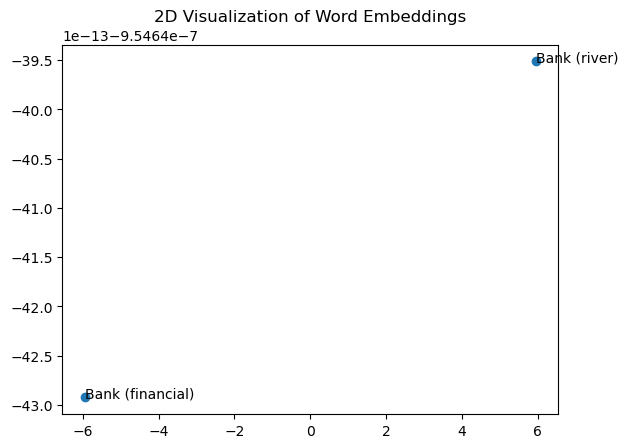

In [51]:
def plot_embeddings(embedding1, embedding2, labels):
    pca = PCA(n_components=2)
    embs = torch.cat([embedding1.unsqueeze(0), embedding2.unsqueeze(0)])
    reduced_embs = pca.fit_transform(embs.detach().numpy())

    plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], marker='o')
    for i, label in enumerate(labels):
        plt.annotate(label, (reduced_embs[i, 0], reduced_embs[i, 1]))
    plt.title("2D Visualization of Word Embeddings")
    plt.show()

plot_embeddings(emb1, emb2, ["Bank (river)", "Bank (financial)"])

In [52]:
# nice so it is possible to find out how far apart the meaning of two sentences are, nbow we jsut need to apply that to our datasheet

## trying to do this fro my dataframes :

In [53]:
print(new_norwegian_model_output.columns)


Index(['text', 'Cleaned Text', 'Tokens', 'matches', 'match_indices',
       'match_count', 'results', 'Alternative_Sentence', 'sentence_cosine',
       'avg_cosine'],
      dtype='object')


In [57]:
!pip install seaborn


/tmp/ipykernel_571/763723358.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cosine_values, shade=True, color="blue", alpha=0.5, bw_adjust=0.5, label="Cosine Similarity")


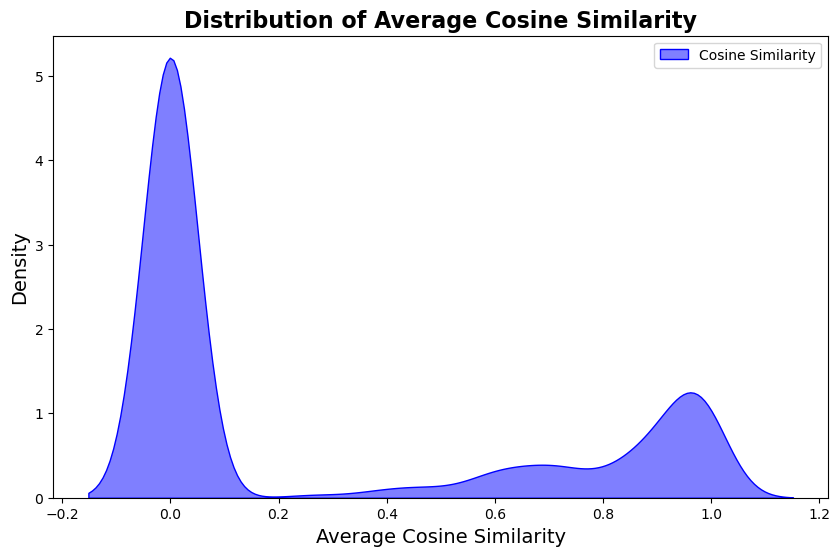

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'avg_cosine' column from the DataFrame
cosine_values = new_norwegian_model_output['avg_cosine']

# Create a plot
plt.figure(figsize=(10, 6))

# Use Seaborn for a KDE plot to show distribution
sns.kdeplot(cosine_values, shade=True, color="blue", alpha=0.5, bw_adjust=0.5, label="Cosine Similarity")

# Add a title and labels
plt.title("Distribution of Average Cosine Similarity", fontsize=16, weight='bold')
plt.xlabel("Average Cosine Similarity", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Show the legend
plt.legend()

# Show the plot
plt.show()


/tmp/ipykernel_571/497294855.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cosine_values, shade=True, color="blue", alpha=0.5, bw_adjust=0.5, label="Cosine Similarity")


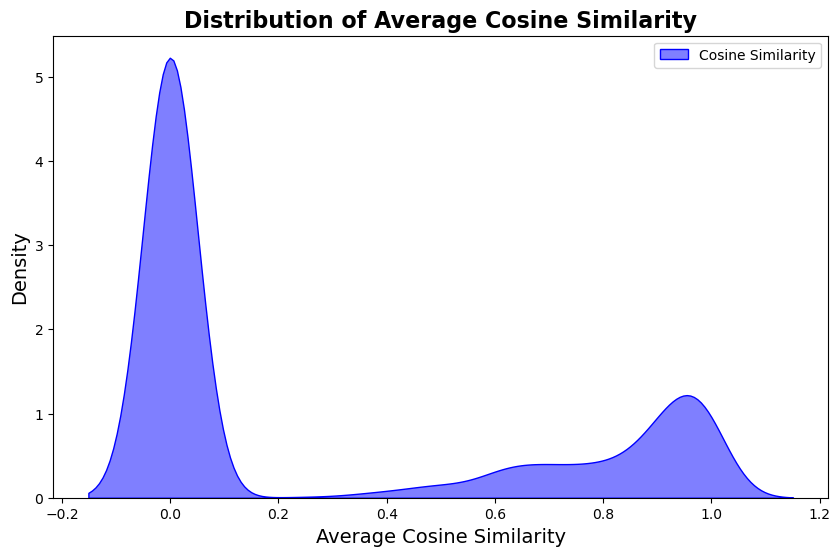

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'avg_cosine' column from the DataFrame
cosine_values = new_royal_lib_model_output['avg_cosine']

# Create a plot
plt.figure(figsize=(10, 6))

# Use Seaborn for a KDE plot to show distribution
sns.kdeplot(cosine_values, shade=True, color="blue", alpha=0.5, bw_adjust=0.5, label="Cosine Similarity")

# Add a title and labels
plt.title("Distribution of Average Cosine Similarity", fontsize=16, weight='bold')
plt.xlabel("Average Cosine Similarity", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Show the legend
plt.legend()

# Show the plot
plt.show()

#new_trained_on_fb

/tmp/ipykernel_571/613286061.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cosine_values, shade=True, color="blue", alpha=0.5, bw_adjust=0.5, label="Cosine Similarity")


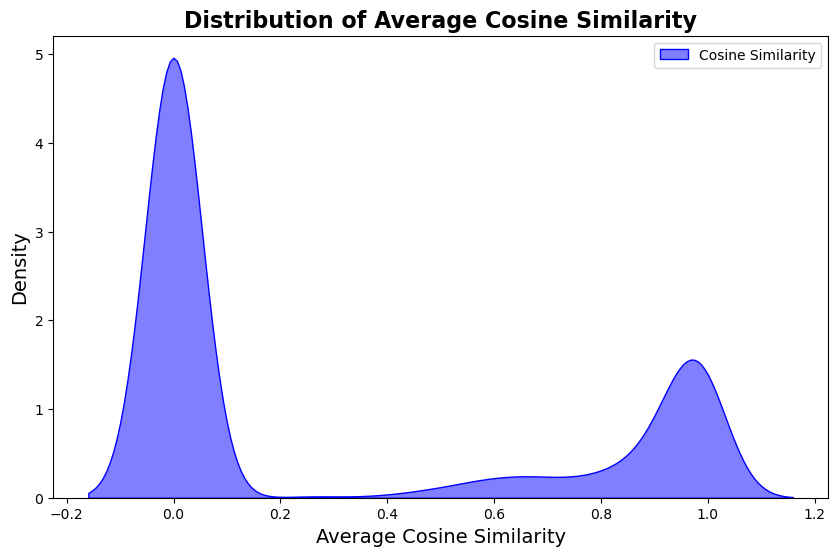

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'avg_cosine' column from the DataFrame
cosine_values = new_trained_on_fb['avg_cosine']

# Create a plot
plt.figure(figsize=(10, 6))

# Use Seaborn for a KDE plot to show distribution
sns.kdeplot(cosine_values, shade=True, color="blue", alpha=0.5, bw_adjust=0.5, label="Cosine Similarity")

# Add a title and labels
plt.title("Distribution of Average Cosine Similarity", fontsize=16, weight='bold')
plt.xlabel("Average Cosine Similarity", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Show the legend
plt.legend()

# Show the plot
plt.show()

#new_trained_on_fb